# [code and data]: Phase diagram of one-dimensional driven-dissipative exciton-polariton condensates

The main article (free access):
https://doi.org/10.1103/PhysRevResearch.5.043062

In this notebook, all the data used for the Figures in the article are given, together with a sample of the code used for the plotting part.


## Model details

The dynamics of the driven-dissipative spatially extendend exciton-polariton condensate (under incoherent driving) is described by the following model.
It consists of two coupled equations for the condensate complex order parametner $\psi(x, t)$ and the real reservoir density $n_R(x, t)$, aka generalized stochastic  Gross-Pitaevskii equation.

\begin{align}
     i\hbar \partial_t &\psi(x, t)= 
     \Big[\epsilon(\hat{k}) + g|\psi(x, t)|^2 + 2g_Rn_R(x,t) +  \frac{i \hbar}{2}\left( R n_R(x,t) - \gamma(\hat{k}) \right) \Big]\psi(x,t) + \hbar \eta(x, t)
\label{eq:sGPE}\\
 \partial_t &n_R(x, t) = P(x)- \left(\gamma_R + R|\psi(x,t)|^2\right)n_R(x, t)
    \label{eq:reservoir}
\end{align}

 with $\hat{k}=-i\partial_x$. See the main article for the physical meaning and values of the parameters involved.

### Tunable parameters:
 - reduced pump $p = P / P_{th}$, unitless number
 - interaction energy with reservoir $\mu_{th} = 2 g_R n_{R,0}$ (in practice tuned by varying $g_R$, at fixed $n_{R,0}=\gamma_0/R$), measured in meV
 - noise strength $\sigma$, measured with respect to its nominal value $\sigma_0 = \gamma_0$
 
### Observables:

#### global observables
- average density $\langle \bar{\rho} \rangle$
- average soliton number $\langle n_s \rangle$
- average vortex density $\langle n_v \rangle$

#### spatio-temporal 
- stationary momentum distribution $n_k$
- space-time correlations $g^{(1)}(\Delta t, \Delta x)$ with time and space separation $\Delta t, \Delta x$
 

## Simulation parameters

#### Units:
- time: $t_0 = 1 $ ps
- space: $a = 4.4$ $\mu m$ (spacing of effective 1D lattice)

#### Discretisation:
for most of the simulations:
- $dt = 0.1 \times t_0$, (approximating continuous time)
- $dx = a$ (for the lattice dynamics)

## List of figures: code and data

In [2]:
#######################################################
###########        INITIALISATION        ##############
#######################################################

# Python modules
import numpy as np
import os 
from scipy.fftpack import fft, fft2, fftfreq, fftshift
import matplotlib.pyplot as plt
import matplotlib as mpl

# custom consensate class
import code_simulations.condensate as condensate

# global location of data
datapath_global = 'data'


# Function to create an instance of the 'condensate' class, simplified to only depend on the parameters:
# - Nx (nb of lattice sites)
# - p (reduced pump)
# - mu (interaction energy, in meV)
# - eta (multiplicative factor for the noise strength, i.e. sigma = eta * sigma_0)
# Note that all the other parameters were kept fixed in the context of this paper

def condensate_call(Nx, p, mu, eta):
    ep = condensate.condensate(N=Nx, eta=0.1, noise_type='fixed', p=p, N_spot=88, N_sig=5, pump_type='homo', 
                                   mass=1.0, dispersion_type='cos', 
                                   gam_0=1.0, gam_2=1.0, gam_type='par', R=1.0, gam_R=1.0, mu_th=mu, g=0, 
                                   psi_in='statio')
    return ep

## Figure 1
<img src="figures_paper/Figure1.png" alt="image" width="250" height="auto">

see the methods of the condensate class for the computation of Bogoliubov spectrum.

## Figure 2

Parameters of the simulation:
$p = 1.15$, 
$\mu_{th} = 0.1$ meV, 
$\sigma = 0.1 \sigma_0 $

#### Figure 2 (a, b) 
<img src="figures_paper/Figure2_ab.png" alt="image" width="450" height="auto">

#### Figure 2 (c, d) 
<img src="figures_paper/Figure2_cd.png" alt="image" width="450" height="auto">

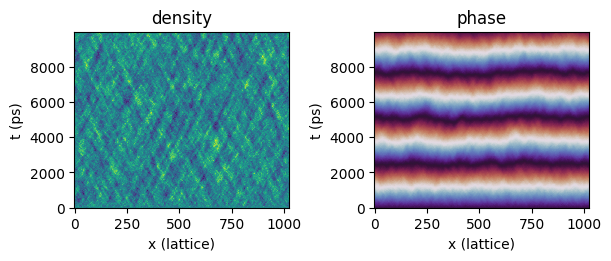

In [154]:
###################
## load data
###################

## data location
datapath = datapath_global + '/Regime_KPZ'

## simulation parameters (for info)
Nx = 1024     # number of lattice points
dt = 0.1      # time discretization

## model parameters for dynamics
p = 1.15
mu = 0.1
eta = 0.1

## example of the condensate dynamics
psi = np.load(datapath + '/psi_p{:.2f}_mu{:.2f}_eta{:.2f}.npy'.format(p, mu, eta))
t_sim = np.load(datapath + '/t_sim.npy')
x_sim = np.arange(Nx)


###################
## plot dynamics
###################

fig, ax = plt.subplots(1, 2, figsize=(6, 2.5), constrained_layout=True)

## plot density
ax[0].set_title('density')
ax[0].pcolormesh(x_sim, t_sim, np.abs(psi)**2)

## plot phase (time slope is changed in order to highlight phase fronts, by tuning 'wr')
ax[1].set_title('phase')
ep = condensate_call(Nx, p, mu, eta) # create condensate to get mu_th in coherent units
wr = 0.9 * ep.mu_th # reference value for the phase slope
ref_wave = np.exp(1j * wr * np.broadcast_to(t_sim, np.shape(psi.T)).T) # reference wave
ax[1].pcolormesh(x_sim, t_sim, np.angle(psi * ref_wave), cmap='twilight')

for axx in ax:
    axx.set_xlabel(r'x (lattice)')
    axx.set_ylabel(r't (ps)')
plt.show()

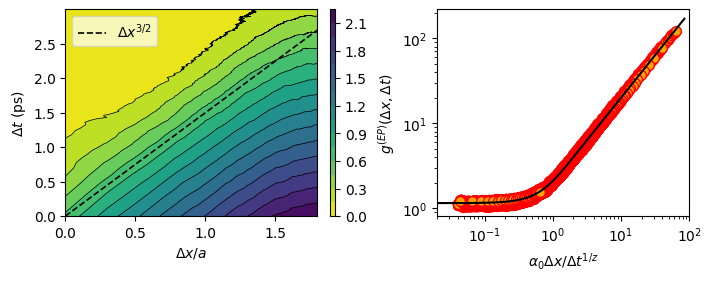

In [150]:
###################
## load data
###################

## data location
datapath = datapath_global + '/Regime_KPZ'

## simulation parameters (for info)
Nx = 128     # number of lattice points
dt = 0.1      # time discretization
t_in = 10000  # initial evolution time (ps) 
N_sim = 1000   # nb of independent simulations

## model parameters for space-time correlations
p = 1.12
mu = 0.1
eta = 0.1
#ep = condensate_call(Nx, p, mu, eta)

## load space-time correlations
# space
x = np.arange(Nx)
# time
t = np.load(datapath + '/t.npy')

# g1 = <psi psi*> / <rho> <rho>
g1 = np.load(datapath + '/g1_p{:.2f}_eta{:.2f}_mu{:.2f}.npy'.format(p, eta, mu)) 

## other correlations (not in the paper)
# g2 = <rho rho> / <rho> <rho>
#g2 = np.load(datapath + '/g2_p{:.2f}_eta{:.2f}_mu{:.2f}.npy'.format(p, eta, mu)) 
# g_exp = <e^(i theta)>
#g_exp = np.load(datapath + '/g_exp_p{:.2f}_eta{:.2f}_mu{:.2f}.npy'.format(p, eta, mu))


####################################################
# Plot contour plot of rescaled phase correlations
####################################################

## critical exponents
beta = 1/3
chi = 0.5
z = chi/beta

## compute the usual approximation of phase-phase correlator from the g1
C1 = -2 * np.log(np.abs(g1)) 

## create 2d arrays of space and time -> homogeneous to correlations in order to do numpy operations
t = np.arange(len(C1[:, 0])) 
x = np.arange(len(C1[0, :]))
T, X = np.meshgrid(t[1:], x[1:], indexing='ij')
Z = C1[1:, 1:]

## rescaling factor, prop to t^{2 beta}
c0 = 1.8e-4
Z0 = c0 * T**(2*beta)

## plot the rescaled phase correlations (level lines)

fig, Ax = plt.subplots(1, 2, figsize=(7, 2.7), layout='constrained')
ax, ax1 = Ax

levels = 15 # number of levels for contour plot

ax.contour(np.log10(X), np.log10(T), np.log10(Z / Z0),
           levels=levels, colors='black', linestyles='solid', linewidths=0.5) # black lines
s = ax.contourf(np.log10(X), np.log10(T), np.log10(Z / Z0), 
                cmap='viridis_r', levels=levels) # colored interpolation

## draw the {t = y0 * (x^z)} guideline -> linear in log-log space
y0 = 0 # arbitrary constant (vertical shift)
xx = np.linspace(np.log10(x[1]), np.log10(x[-1]), 2) 
yy = (z)*xx  + y0
ax.plot(xx, yy, color='black', label=r'$\Delta x^{3/2}$', linewidth=1.2, linestyle='dashed')
ax.legend(loc=2, framealpha=0.7)

cbar = fig.colorbar(s, ax=ax, aspect=40)
ax.set_xlabel(r'$\Delta x / a$')
ax.set_ylabel(r'$\Delta t$ (ps)')

######################
# Data collapse (KPZ)
######################

## compute the usual approximation of phase-phase correlator from the g1
C1 = -2 * np.log(np.abs(g1)) 

## create 2d arrays of space and time -> homogeneous to correlations in order to do numpy operations
t = np.arange(len(C1[:, 0])) 
x = np.arange(len(C1[0, :]))
T, X = np.meshgrid(t[1:], x[1:], indexing='ij')

## rescale by t^{2 beta}
Z = C1[1:, 1:] / T**(2*beta)
Y = X / T**(1/z)

## select space-time window
r = 400
x_max = 30
sel = np.logical_and(X < x_max, T < X**(z) * r)

## flatten the 2d arrays into 1d (collapsed) data
y = Y[sel].flatten()
c = Z[sel].flatten()

ax1.set_xlabel(r'$\alpha_0 \Delta x / \Delta t^{1/z}$')
#ax1.set_ylabel(r'$-2\mathrm{log}\left(|g_1(\Delta x, \Delta t)|\right) / C_0 \Delta t^{2\beta}$', fontsize=s_axlabel)
ax1.set_ylabel(r'$g^{(EP)}(\Delta x, \Delta t)$')

## non-universal constants for the collapse
c0 = 1.8e-4 # vertical shift
y0 = 2.2    # horizontal shift

## plot the collapsed data
ax1.scatter(y * y0, c/c0, marker='o', s=50, label=r'$g^{(EP)}$', alpha=1, facecolors='orange', edgecolors='red')

## plot exact kpz scaling function from Praofer-Spohn
kpz_theory = np.loadtxt(datapath + '/g_scaling_theory.txt')
y_th, g_th = kpz_theory[:, 0], kpz_theory[:, 1]
ax1.plot(y_th, g_th, color='black')

# add asymptotic prolongation (linear)
yy_th = np.linspace(y_th[-1], 85, 2)
gg_th = g_th[-1] + 2 * (yy_th - yy_th[0])
ax1.plot(yy_th, gg_th, color='black')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(2e-2, 1e2)

plt.show()

## Figure 3
Parameters of the simulation:
$p = 1.25$,
$\mu_{th} = 0.29$ meV,
$\sigma = 0.1 \sigma_0 $
#### Figure 3 (a, b) 
<img src="figures_paper/Figure3_ab.png" alt="image" width="450" height="auto">

#### Figure 3 (c, d) 
<img src="figures_paper/Figure3_cd.png" alt="image" width="450" height="auto">

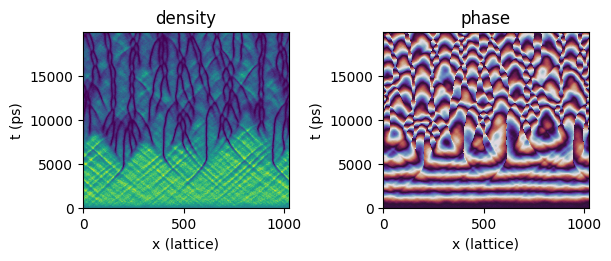

In [149]:
###################
## load data
###################

## data location
datapath = datapath_global + '/Regime_Solitons'

## simulation parameters (for info)
Nx = 1024    # number of lattice points
dt = 0.1 # time discretization

## model parameters
p = 1.25
mu = 0.29
eta = 0.1
ep = condensate_call(Nx, p, mu, eta)

## example of the condensate dynamics
psi = np.load(datapath + '/psi_p{:.2f}_mu{:.2f}_eta{:.2f}.npy'.format(p, mu, eta))
t_sim = np.load(datapath + '/t_sim.npy')
x_sim = np.arange(Nx)

###################
## plot dynamics
###################

fig, ax = plt.subplots(1, 2, figsize=(6, 2.5), constrained_layout=True)

## plot density
ax[0].set_title('density')
ax[0].pcolormesh(x_sim, t_sim, np.abs(psi)**2)

## plot phase (time slope is changed in order to highlight phase fronts, by tuning 'wr')
ax[1].set_title('phase')
wr = 10.05 * ep.mu_th # reference value for the phase slope
ref_wave = np.exp(1j * wr * np.broadcast_to(t_sim, np.shape(psi.T)).T) # reference wave
ax[1].pcolormesh(x_sim, t_sim, np.angle(psi * ref_wave), cmap='twilight')

for axx in ax:
    axx.set_xlabel(r'x (lattice)')
    axx.set_ylabel(r't (ps)')
plt.show()

(999, 63)


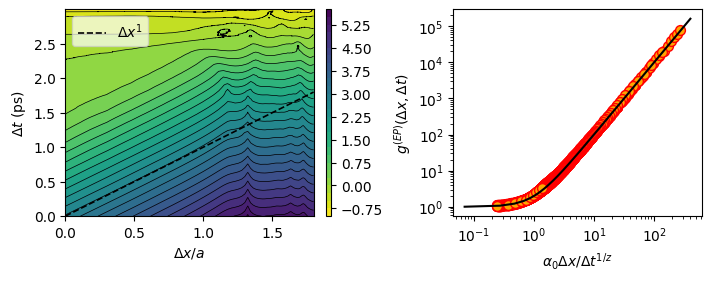

In [148]:
###################
## load data
###################

## data location
datapath = datapath_global + '/Regime_Solitons'

## simulation parameters (for info)
Nx = 128      # number of lattice points
dt = 0.1      # time discretization
t_in = 10000  # initial evolution time (ps) 
N_sim = 100   # nb of independent simulations

## model parameters for space-time correlations
mu = 0.6
p = 1.5
eta = 0.1
#ep = condensate_call(Nx, p, mu, eta)

## load space-time correlations
# space
x = np.arange(Nx//2)
# time
t = np.load(datapath + '/t.npy')

# g1 = <psi psi*> / <rho> <rho>
g1 = np.load(datapath + '/g1_p{:.2f}_eta{:.2f}_mu{:.2f}.npy'.format(p, eta, mu)) 

## other correlations (not in the paper)
# g2 = <rho rho> / <rho> <rho>
#g2 = np.load(datapath + '/g2_p{:.2f}_eta{:.2f}_mu{:.2f}.npy'.format(p, eta, mu)) 
# g_exp = <e^(i theta)>
#g_exp = np.load(datapath + '/g_exp_p{:.2f}_eta{:.2f}_mu{:.2f}.npy'.format(p, eta, mu))

####################################################
# Plot contour plot of rescaled phase correlations
####################################################

## critical exponents
beta = 1.
chi = 1.
z = chi/beta

fig, Ax = plt.subplots(1, 2, figsize=(7, 2.7), layout='constrained')
ax, ax1 = Ax

## compute the usual approximation of phase-phase correlator from the g1
C1 = -2 * np.log(np.abs(g1)) 

## create 2d arrays of space and time -> homogeneous to correlations in order to do numpy operations
T, X = np.meshgrid(t[1:], x[1:], indexing='ij')
Z = C1[1:, 1:]

print(np.shape(Z))
## rescaling factor, prop to t^{2 beta}
c0 = 4.05e-05
Z0 = c0 * T**(2*beta)

## plot the rescaled phase correlations (level lines)
levels = 25 # number of levels for contour plot
ax.contour(np.log10(X), np.log10(T), np.log10(Z / Z0),
           levels=levels, colors='black', linestyles='solid', linewidths=0.5) # black lines
s = ax.contourf(np.log10(X), np.log10(T), np.log10(Z / Z0), 
                cmap='viridis_r', levels=levels) # colored interpolation

## draw the {t = y0 * (x^z)} guideline -> linear in log-log space
y0 = 0 # arbitrary constant (vertical shift)
xx = np.linspace(np.log10(x[1]), np.log10(x[-1]), 2) 
yy = (z)*xx  + y0
ax.plot(xx, yy, color='black', label=r'$\Delta x^{1}$', linewidth=1.2, linestyle='dashed')
ax.legend(loc=2, framealpha=0.7)

cbar = fig.colorbar(s, ax=ax, aspect=40)
ax.set_xlabel(r'$\Delta x / a$')
ax.set_ylabel(r'$\Delta t$ (ps)')


############################
# Data collapse (Solitons)
############################

## compute the usual approximation of phase-phase correlator from the g1
C1 = -2 * np.log(np.abs(g1)) 

## create 2d arrays of space and time -> homogeneous to correlations in order to do numpy operations
T, X = np.meshgrid(t[1:200], x[1:], indexing='ij')

## rescale by t^{2 beta}
Z = C1[1:200, 1:] / T**(2*beta)
Y = X / T**(1/z)

## select space-time window
r = 100
x_max = 12
sel = np.logical_and(X < x_max, T < X**(z) * r)

## flatten the 2d arrays into 1d (collapsed) data
y = Y[sel].flatten()
c = Z[sel].flatten()

ax1.set_xlabel(r'$\alpha_0 \Delta x / \Delta t^{1/z}$')
#ax1.set_ylabel(r'$-2\mathrm{log}\left(|g_1(\Delta x, \Delta t)|\right) / C_0 \Delta t^{2\beta}$', fontsize=s_axlabel)
ax1.set_ylabel(r'$g^{(EP)}(\Delta x, \Delta t)$')

## non-universal constants for the collapse
c0 = 4.05e-05   # vertical shift
y0 = 23*1.05    # horizontal shift

## plot the collapsed data
ax1.scatter(y * y0, c/c0, marker='o', s=50, label=r'$g^{(EP)}$', alpha=1, facecolors='orange', edgecolors='red')

## plot the scaling function 
yy = np.linspace(0.07, 4e2, 2000)
gg0, A = 1, 1
gg2 = gg0 * (1 + (A * yy)**2)
ax1.plot(yy, gg2 , color='black', label=r'$g^{(\rm sol)}$  ')

ax1.set_xscale('log')
ax1.set_yscale('log')

plt.show()

## Figure 4

### Figure 4 (a, b) 
<img src="figures_paper/Figure4_ab.png" alt="image" width="400" height="auto">

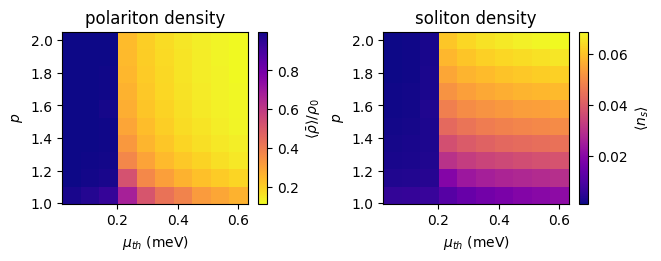

In [147]:
###################
## load data
###################

## data location
datapath = datapath_global + '/PhaseDiagram_p_mu'

## simulation parameters (for info)
Nx = 1024    # number of lattice points
t_in = 50000 # initial time to reach stationary state (units: ps)
t_sim = 5000 # time of each simulation (units: ps)
N_sim = 1000 # nb of simulations

## model parameters
eta = 0.1
mu_list = np.load(datapath + '/mu_list.npy')  #mu_list = np.linspace(0.05, 0.6, 10)
p_list  = np.load(datapath + '/p_list.npy')   #p_list  = np.linspace(1.05, 2, 10)

## observables
rho = np.load(datapath + '/rho.npy')  # polariton densities
ns  = np.load(datapath + '/ns.npy')   # soliton densities
nk  = np.load(datapath + '/nk.npy')   # momentum distributions
k   = np.load(datapath + '/k.npy')    # momentum grid (units: pi/a) k=2*np.pi*fftshift(fftfreq(1024, 1))

##################################
## Plot data of Figure 4 (a), (b)
##################################

## make figure frame
fig, Ax = plt.subplots(1, 2, figsize=(6.5, 2.5), constrained_layout=True)
ax, ax1 = Ax

## averagae density
ax.set_title('polariton density')
s = ax.pcolormesh(mu_list, p_list, rho, cmap='plasma_r')
ax.set_xlabel(r'$\mu_{th}$ (meV)')
ax.set_ylabel(r'$p$')
cbar = fig.colorbar(s, ax = ax)
cbar.set_label(r'$\langle \bar{\rho} \rangle / \rho_0$')

## soliton density ns
ax1.set_title('soliton density')
s1 = ax1.pcolormesh(mu_list, p_list, ns, cmap='plasma')
ax1.set_xlabel(r'$\mu_{th}$ (meV)')
ax1.set_ylabel(r'$p$')
cbar1 = fig.colorbar(s1, ax = ax1)
cbar1.set_label(r'$\langle n_s \rangle $')

plt.show()

### Figure 4 (c, d) 
<img src="figures_paper/Figure4_cd.png" alt="image" width="400" height="auto">

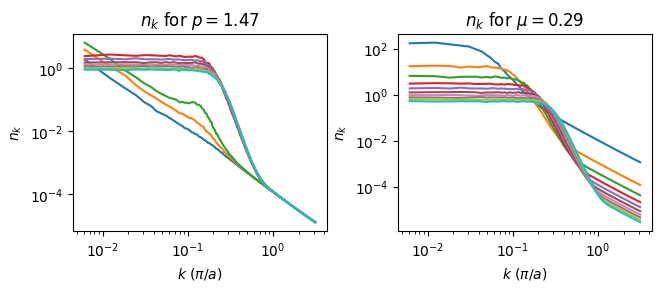

In [4]:
###################
## load data
###################

## data location
datapath = datapath_global + '/PhaseDiagram_p_mu'

## simulation parameters (for info)
Nx = 1024    # number of lattice points
t_in = 50000 # initial time to reach stationary state (units: ps)
t_sim = 5000 # time of each simulation (units: ps)
N_sim = 1000 # nb of simulations

## model parameters
eta = 0.1
mu_list = np.load(datapath + '/mu_list.npy')  #mu_list = np.linspace(0.05, 0.6, 10)
p_list  = np.load(datapath + '/p_list.npy')   #p_list  = np.linspace(1.05, 2, 10)

## observables
rho = np.load(datapath + '/rho.npy')  # polariton densities
ns  = np.load(datapath + '/ns.npy')   # soliton densities
nk  = np.load(datapath + '/nk.npy')   # momentum distributions
k   = np.load(datapath + '/k.npy')    # momentum grid (units: pi/a) k=2*np.pi*fftshift(fftfreq(1024, 1))

##################################
## Plot data of Figure 4 (c), (d)
##################################

fig, Ax = plt.subplots(1, 2, layout='constrained', figsize=(6.5, 2.8))
ax, ax1 = Ax

## nk for fixed pump
i_p = 4
p = p_list[i_p]
ax.set_title(r'$n_k$ for $p=${:.2f}'.format(p))
for i in range(10):
    mu = mu_list[i]
    ep = condensate_call(Nx, p, mu, eta) # create a condensate class 'ep'
    rho0 = ep.rho # nominal condensate density
    ax.loglog(k[k>0], nk[i_p, i, k>0] * 2*np.pi  * (1/Nx) / rho0) 
ax.set_xlabel(r'$k$ $(\pi / a)$')
ax.set_ylabel(r'$n_k$')

## nk for fixed interaction energy mu_th
i_mu = 4
mu = mu_list[i_mu]
ax1.set_title(r'$n_k$ for $\mu = ${:.2f}'.format(mu))
for i in range(10):
    p = p_list[i]
    ep = condensate_call(Nx, p, mu, eta) # create a condensate class 'ep'
    rho0 = ep.rho # nominal condensate density
    ax1.loglog(k[k>0], nk[i, i_mu, k>0] * 2*np.pi  * (1/Nx) / rho0)
    ## with momentum rescaling by pump-dependent factor:
    #k_resc = k[k>0]/ ((p-1))**.5
    #ax1.loglog(k_resc, nk[i, i_mu, k>0] * 2*np.pi  * (1/Nx) / rho0)
ax1.set_xlabel(r'$k$ $(\pi / a)$')
ax1.set_ylabel(r'$n_k$')

plt.show()

## Figure 5
Parameters of the simulation:
$p = 1.15$,
$\mu_{th} = 0.10$ meV,
$\sigma = 5.0 \sigma_0 $,
<img src="figures_paper/Figure5.png" alt="image" width="350" height="auto">

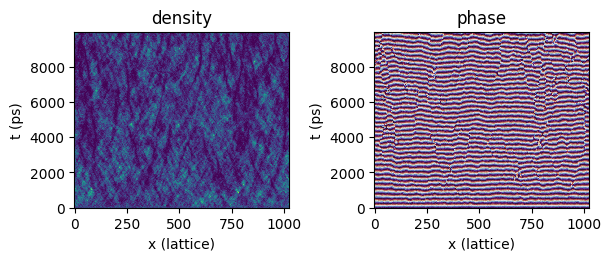

In [145]:
###################
## load data
###################

## data location
datapath = datapath_global + '/Regime_Vortices'

## simulation parameters (for info)
Nx = 1024    # number of lattice points
dt = 0.1 # time discretization

## model parameters
p = 1.15
mu = 0.1
eta = 5.0
ep = condensate_call(Nx, p, mu, eta)

## example of the condensate dynamics
psi = np.load(datapath + '/psi_p{:.2f}_mu{:.2f}_eta{:.2f}.npy'.format(p, mu, eta))
t_sim = np.load(datapath + '/t_sim.npy')
x_sim = np.arange(Nx)

###################
## plot dynamics
###################

fig, ax = plt.subplots(1, 2, figsize=(6, 2.5), constrained_layout=True)

## plot density
ax[0].set_title('density')
ax[0].pcolormesh(x_sim, t_sim, np.abs(psi)**2)

## plot phase (time slope is changed in order to highlight phase fronts, by tuning 'wr')
ax[1].set_title('phase')
wr = 0. * ep.mu_th # reference value for the phase slope
ref_wave = np.exp(1j * wr * np.broadcast_to(t_sim, np.shape(psi.T)).T) # reference wave
ax[1].pcolormesh(x_sim, t_sim, np.angle(psi * ref_wave), cmap='twilight')

for axx in ax:
    axx.set_xlabel(r'x (lattice)')
    axx.set_ylabel(r't (ps)')
plt.show()

## Figure 6
<img src="figures_paper/Figure6.png" alt="image" width="450" height="auto">

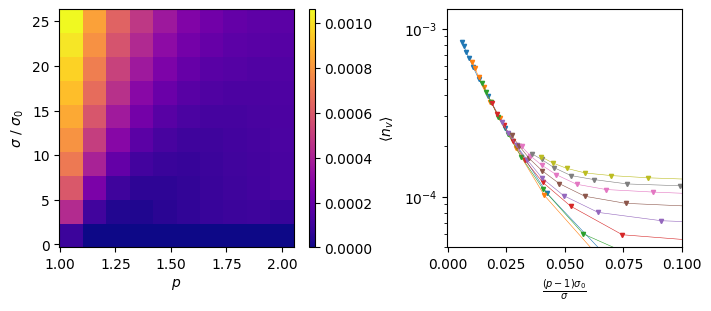

In [144]:
###################
## load data
###################

## data location
datapath = datapath_global + '/PhaseDiagram_p_sigma'

## simulation parameters (for info)
Nx = 1024    # number of lattice points
t_sim = 1000 # time of each simulation (units: ps)
N_sim = 500 # nb of simulations

## model parameters
mu = 0.1
eta_list = np.load(datapath + '/eta_list.npy')  # eta_list = np.linspace(1, 25, 10)
p_list  = np.load(datapath + '/p_list.npy')   # p_list  = np.linspace(1.05, 2, 10)

## observables
Nv_all = np.load(datapath + '/Nv_all.npy')  # number of vortices
nv_plus, nv_minus  = Nv_all[:, :, 0],  Nv_all[:, :, -1]

##################################
## Plot data of Figure 6 (a), (b)
##################################
Nv = np.sum(Nv_all, axis=2) # sum of average density of negatively + positively charged vortices

fig, Ax = plt.subplots(1, 2, figsize=(7, 3), constrained_layout=True)
ax, ax1 = Ax

## plot Nv in the (p, sigma) plane
s = ax.pcolormesh(p_list, eta_list, Nv.T, cmap='plasma')
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$\sigma$ / $\sigma_0$')
cbar = fig.colorbar(s, ax=ax, aspect=40)
cbar.set_label(r'$\langle n_v \rangle$')

## plot avg Nv versus (p-1)/sigma (collapse on exponential law in the small argument region)
for j in range(1, 10):
    p = p_list[j]
    ax1.semilogy((p-1)/eta_list, Nv[j, :], lw=0.4, marker='v', markersize=3)   
ax1.set_xlabel(r'$\frac{(p-1) \sigma_0}{\sigma}$')
ax1.set_xlim(-.0001, .1)
ax1.set_ylim(.5e-4, 1.3e-3)

plt.show()

## Figure 7
<img src="figures_paper/Figure7.png" alt="image" width="400" height="auto">

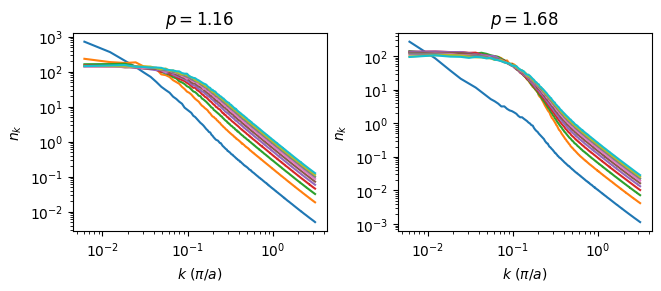

In [5]:
###################
## load data
###################

## data location
datapath = datapath_global + '/PhaseDiagram_p_sigma'

## simulation parameters (for info)
Nx = 1024    # number of lattice points
t_sim = 1000 # time of each simulation (units: ps)
N_sim = 500 # nb of simulations

## model parameters
mu = 0.1
eta_list = np.load(datapath + '/eta_list.npy')  # eta_list = np.linspace(1, 25, 10)
p_list  = np.load(datapath + '/p_list.npy')   # p_list  = np.linspace(1.05, 2, 10)

## observables
nk_all = np.load(datapath + '/nk_all.npy')  # momentum distributions
k = np.load(datapath + '/k.npy')  # momentum grid

##################################
## Plot data of Figure 7 (a), (b)
##################################

ip1, ip2 = 1, 6 # indexes of 2 fixed pump values

fig, ax = plt.subplots(1, 2, figsize=(6.5, 2.8), layout='constrained')

ax[0].set_title(r'$p=${:.2f}'.format(p_list[ip1]))
ax[1].set_title(r'$p=${:.2f}'.format(p_list[ip2]))

## plot nk for each value of the noise, 2 fixed pump values:
for j in range(10):
    ## noise
    eta = eta_list[j]
    
    ## first pump value
    p = p_list[ip1]
    ep = condensate_call(Nx, p, mu, eta) # create a condensate class 'ep'
    rho0 = ep.rho # nominal condensate density
    nk = nk_all[1, j, :]
    ax[0].loglog(k[k>0], nk[k>0] * 2 * np.pi * (1/Nx) / rho0) # normalize by condensate nominal density ep.rho
    
    ## second pump value
    p = p_list[ip2]
    ep = condensate_call(Nx, p, mu, eta)
    rho0 = ep.rho
    nk = nk_all[6, j, :]
    ax[1].loglog(k[k>0], nk[k>0] * 2 * np.pi * (1/Nx) / rho0)
    
ax[0].set_xlabel(r'$k$ ($\pi/a$)')
ax[0].set_ylabel(r'$n_k$')
ax[1].set_xlabel(r'$k$ ($\pi/a$)')
ax[1].set_ylabel(r'$n_k$')

plt.show()

## Figure 8
<img src="figures_paper/Figure8.png" alt="image" width="450" height="auto">

### Figure 8 (a): splitting of phase-phase correlations

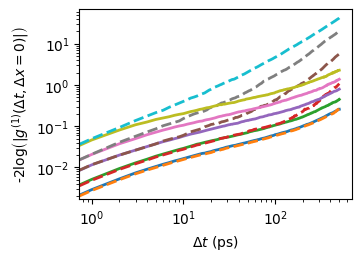

In [139]:
###################
## load data
###################

## data location
datapath = datapath_global + '/Regime_Vortices/correlation_split'

## simulation parameters (for info)
Nx = 128      # number of lattice points
dt = 0.1      # time discretization
t_in = 10000  # initial evolution time (ps) 
N_sim = 100   # nb of independent simulations

## model parameters
mu = 0.10
p = 1.26
eta_list = np.geomspace(0.5, 50., 10) # evenly-spaced noise values in log scale

## load time correlations
t = np.arange(1000) # time in (ps)
C_list = np.load(datapath + '/C_list_p{:.2f}_mu{:.2f}.npy'.format(p, mu)) # list of different temporal correlations [for eta in eta_list]

##############################
## plot correlation splitting
##############################

t1 = 500 # end of time window for the plot

fig, ax1 = plt.subplots(1, figsize=(3.5, 2.5), layout='constrained')

for j in range(5):
    C = C_list[5+j, :, :]
    
    # unfolding the correlations:
    C_ph, g_exp, g1, g2 = np.abs(C[0]), np.abs(C[1]), np.abs(C[2]), np.abs(C[3])
    
    # compute approx phase correlations from <e^{i theta}>
    C_exp = -2*np.log(np.abs(g_exp))
    ax1.loglog(t[:t1], C_exp[:t1], label=r'$\langle e^{i\left[\theta(t)-\theta(0)\right]} \rangle$', linewidth=2)
    
    # plot the phase-phase correlations computed directly on the phase field, i.e. 'C_ph'
    ax1.loglog(t[:t1], C_ph[:t1], linestyle='dashed', label=r'$C_{\theta}(t)$', linewidth=2)

## labels
ax1.set_xlabel(r'$\Delta t$ (ps)')
ax1.set_ylabel(r'-2log$\left( |g^{(1)}(\Delta t, \Delta x=0)| \right)$')

plt.show()

### Figure 8 (b): space-time correlations in the vortex-regime

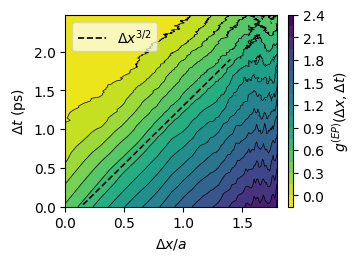

In [140]:
###################
## load data
###################

## data location
datapath = datapath_global + '/Regime_Vortices'

## simulation parameters (for info)
Nx = 128      # number of lattice points
dt = 0.1      # time discretization
t_in = 10000  # initial evolution time (ps) 
N_sim = 100   # nb of independent simulations

## model parameters for space-time correlations
mu = 0.1
p = 1.12
eta = 25.0
#ep = condensate_call(Nx, p, mu, eta)

## load space-time correlations
# space
x = np.arange(Nx//2)
# time
t = np.load(datapath + '/t.npy')

# g1 = <psi psi*> / <rho> <rho>
g1 = np.load(datapath + '/g1_p{:.2f}_eta{:.2f}_mu{:.2f}.npy'.format(p, eta, mu)) 

## other correlations (not in the paper)
# g2 = <rho rho> / <rho> <rho>
#g2 = np.load(datapath + '/g2_p{:.2f}_eta{:.2f}_mu{:.2f}.npy'.format(p, eta, mu)) 
# g_exp = <e^(i theta)>
#g_exp = np.load(datapath + '/g_exp_p{:.2f}_eta{:.2f}_mu{:.2f}.npy'.format(p, eta, mu))

####################################################
# Make contour plot of rescaled phase correlations
####################################################

## critical exponents (KPZ)
beta = 1/3
chi = 0.5
z = chi/beta

## usual approximation of the phase-phase correlator from the g1
C1 = -2 * np.log(np.abs(g1))

## meshgrids for plotting
T, X = np.meshgrid(t[1:], x[1:], indexing='ij')
Z = C1[1:, 1:]

# rescaling by t^{2 beta}
c0 = 1.8e-4 * (eta / 0.1)
Z0 = c0 * T**(2*beta)

## plotting
fig, ax2 = plt.subplots(1, figsize=(3.5, 2.5), layout='constrained')

levels = 20 # nb of levels for contour plot
ax2.contour(np.log10(X), np.log10(T), np.log10(Z / Z0), levels=levels, colors='black', linestyles='solid', linewidths=0.5)
s = ax2.contourf(np.log10(X), np.log10(T), np.log10(Z / Z0), cmap='viridis_r', levels=levels)

## plot the t = y0 * x^{z} guideline (linear in the log-log scale)
x0, x1, y0 = 0.15, 1.4, -.2
xx = np.linspace(x0, x1, 2)
yy = (z)*xx  + y0
ax2.plot(xx, yy, color='black', label=r'$\Delta x^{3/2}$', linewidth=1.2, linestyle='dashed')

## labels
ax2.legend(loc=2, framealpha=0.7)
cbar = fig.colorbar(s, ax=ax2, aspect=40)
cbar.set_label(r'$g^{(EP)}(\Delta x, \Delta t)$')
ax2.set_xlabel(r'$\Delta x / a$')
ax2.set_ylabel(r'$\Delta t$ (ps)')

plt.show()


## Figure 9
Parameters of the simulation:
$p = 1.25$,
$\mu_{th} = 0.29$ meV,
$\sigma = 0.1 \sigma_0 $,
<img src="figures_paper/Figure9.png" alt="image" width="250" height="auto">

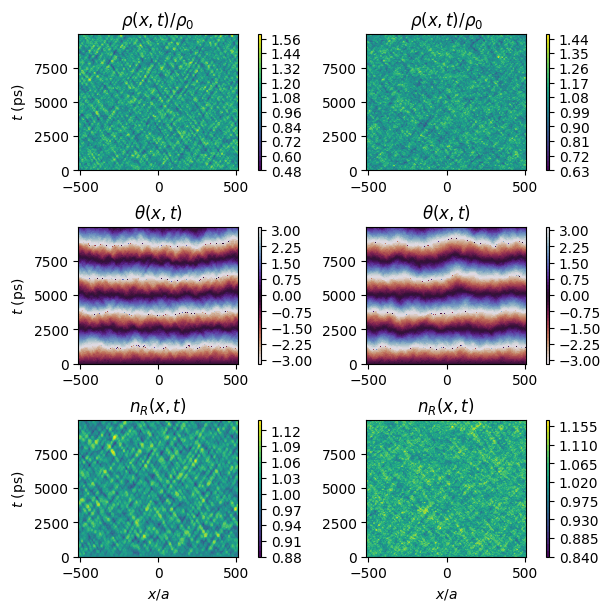

In [6]:
###################
## load data
##################

datapath = datapath_global + '/Regime_Reservoir'

# simulation parameters
dt = 0.1

# model parameters
eta = 1.0
Nx = 1024
mu = 0.1
p = 1.68
ep = condensate_call(Nx, p, mu, eta)

# load and normalize realisations of dynamics: condensate (psi) and reservoir density (nR)
psi = np.load(datapath + '/psi_mu{:.2f}_p{:.2f}_eta{:.2f}.npy'.format(mu, p, eta))
psi /= np.sqrt(ep.rho)
nR = np.load(datapath + '/nR_mu{:.2f}_p{:.2f}_eta{:.2f}.npy'.format(mu, p, eta))
nR /= (ep.gam_0 / ep.R)

psi_AD = np.load(datapath + '/psi_AD_mu{:.2f}_p{:.2f}_eta{:.2f}.npy'.format(mu, p, eta)) 
psi_AD /= np.sqrt(ep.rho)
nR_AD = np.load(datapath + '/nR_AD_mu{:.2f}_p{:.2f}_eta{:.2f}.npy'.format(mu, p, eta)) 
nR_AD /= (ep.gam_0 / ep.R)
                                
t = np.load(datapath + '/t.npy')
x = np.arange(Nx) - Nx/2
                
                
###################
## plot
##################

fig, ax = plt.subplots(3, 2, figsize=(6,6), layout='constrained')

T, X = np.meshgrid(t, x, indexing='ij')

# nonadiabatic evolution
s = ax[0, 0].contourf(x[np.arange(Nx)%4==0], t, np.abs(psi[:, np.arange(Nx)%4==0])**2, levels=30)
s2 = ax[2, 0].contourf(x[np.arange(Nx)%4==0], t, nR[:, np.arange(Nx)%4==0], levels=30)
s1 = ax[1, 0].contourf(x[np.arange(Nx)%4==0], t, np.angle(psi[:, np.arange(Nx)%4==0] * np.exp(1j * .09 * ep.mu_th * 10 * T[:, np.arange(Nx)%4==0])), cmap='twilight_r', levels=50)

ax[0, 0].set_title(r'$\rho(x, t) / \rho_0$')
ax[1, 0].set_title(r'$\theta(x, t)$')
ax[2, 0].set_title(r'$n_R(x, t)$')
cb = plt.colorbar(s, ax=ax[0, 0], aspect=40)
cb1 = plt.colorbar(s1, ax=ax[1, 0], aspect=40)
cb2 = plt.colorbar(s2, ax=ax[2, 0], aspect=40)

# adiabatic evolution
ss = ax[0, 1].contourf(x[np.arange(Nx)%4==0], t, np.abs(psi_AD[:, np.arange(Nx)%4==0])**2, levels=30)
ss2 = ax[2, 1].contourf(x[np.arange(Nx)%4==0], t, nR_AD[:, np.arange(Nx)%4==0], levels=30)
ss1 = ax[1, 1].contourf(x[np.arange(Nx)%4==0], t, np.angle(psi_AD[:, np.arange(Nx)%4==0] * np.exp(1j * .09 * ep.mu_th * 10 * T[:, np.arange(Nx)%4==0])), cmap='twilight_r', levels=50)

ax[0, 1].set_title(r'$\rho(x, t) / \rho_0$')
ax[1, 1].set_title(r'$\theta(x, t)$')
ax[2, 1].set_title(r'$n_R(x, t)$')
cb = plt.colorbar(ss, ax=ax[0, 1], aspect=40)
cb1 = plt.colorbar(ss1, ax=ax[1, 1], aspect=40)
cb2 = plt.colorbar(ss2, ax=ax[2, 1], aspect=40)

for i in range(3):
    for j in range(2):
        ax[2,j].set_xlabel(r'$x/a$')
        ax[i,0].set_ylabel(r'$t$ (ps)')

plt.show()

## Figure 10
<img src="figures_paper/Figure10.png" alt="image" width="250" height="auto">

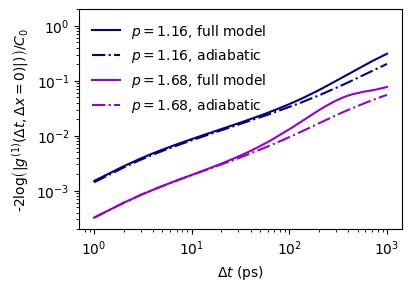

In [41]:
###################
## load and plot
##################

datapath = datapath_global + '/Regime_Reservoir'

# simulation parameters
dt = 0.1
Nt = 1000

# model parameters
eta = 1.0
Nx = 1024
mu = 0.1
p_list = [1.16, 1.68]
t = np.arange(Nt)

## plotting
fig, ax = plt.subplots(1, figsize=(4, 2.8), layout='constrained')

colors = ['darkblue', 'darkviolet']

for i in range(2):
    p = p_list[i]
    g1_AD = np.load(datapath + '/g1t_mu{:.1f}_p{:.2f}_eta{:.1f}_AD.npy'.format(mu, p, eta))
    g1_NA = np.load(datapath + '/g1t_mu{:.1f}_p{:.2f}_eta{:.1f}.npy'.format(mu, p, eta))
    C1_ad = -2*np.log(np.abs(g1_AD))
    C1_na = -2*np.log(np.abs(g1_NA))
    ax.loglog(t[1:], C1_na[1:], c=colors[i], label=r'$p=${:.2f}, full model'.format(p))
    ax.loglog(t[1:], C1_ad[1:], c=colors[i], ls='dashdot', label=r'$p=${:.2f}, adiabatic'.format(p))

# visual settings
ax.set_xlabel(r'$\Delta t$ (ps)')
ax.set_ylabel(r'-2log$\left( |g^{(1)}(\Delta t, \Delta x=0)| ) \right) / C_0$')
ax.legend(frameon=False)
ax.set_ylim(2e-4, 2e0)

plt.show()

## Figure 11
<img src="figures_paper/Figure11.png" alt="image" width="450" height="auto">

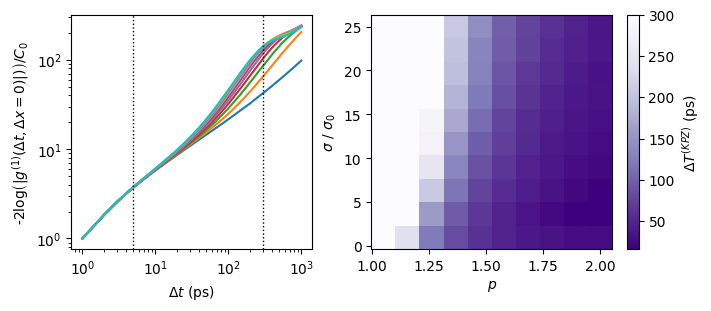

In [142]:
###################
## load data
###################

## data location
datapath = datapath_global + '/PhaseDiagram_p_sigma'

## simulation parameters (for info)
Nx = 1024    # number of lattice points
t_sim = 1000 # time of each simulation (units: ps)
N_sim = 500 # nb of simulations

t = np.arange(t_sim)

## model parameters
mu = 0.1
eta_list = np.load(datapath + '/eta_list.npy')  # eta_list = np.linspace(1, 25, 10)
p_list  = np.load(datapath + '/p_list.npy')   # p_list  = np.linspace(1.05, 2, 10)

## observables
g1t_all = np.load(datapath + '/g1t_all.npy')  # g(1) correlation function in x=0
t = np.load(datapath + '/t.npy')  # time grid

###############################################
## code for computing critical KPZ time window
###############################################

## functions
def d_log(g1): # log derivative
    y = -2*np.log(np.abs(g1))
    x = np.arange(len(g1))
    d_log = np.gradient(np.log(y)) / np.gradient(np.log(x))
    return d_log

def tc_g1(g1, t0, tf, beta_th): # compute time after which the (log-log) slope excesses the threshold beta_th
    m = 0.5
    t1 = t0+10
    while m < 2 * beta_th:
        y = -2*np.log(np.abs(g1[t0:t1]))
        x = np.arange(t1-t0) + t0
        yy = np.log(y)
        xx = np.log(x)
        m, q = np.polyfit(xx, yy, 1)
        t1 += 1
        if t1 >= tf: break
    return t1

## computation of critical time tc(sigma, p), with beta_th=0.35

t0, t1 = 5, 300 # extremes of time interval (ps) for the slope computation
tc = np.zeros((10, 10))
for i in range(10):
    for j in range(10):
        g1t = g1t_all[i, j, :] # correlation function computed in the (i,j) point in the (sigma, p) plane
        C1 = -2*np.log(np.abs(g1t)) # get the usual approximation of the phase-phase correlator
        tc[i, j] = tc_g1(g1t, t0, t1, 0.35) # compute tc
        
######################################
## Plot data of Figure 11 (a), (b)
######################################

fig, ax = plt.subplots(1, 2, figsize=(7, 3), layout='constrained')

## plot the time correlations for fixed noise, all pump values:
j=0
eta = eta_list[j]  # fixed noise value
for i in range(10):
    g1t = g1t_all[i, j, :]
    C1 = -2*np.log(np.abs(g1t))
    ax[0].loglog(t[1:], C1[1:]/C1[1])  # plot time correlations
ax[0].axvline(t0, ls='dotted', c='k', lw=1)
ax[0].axvline(t1, ls='dotted', c='k', lw=1)
ax[0].set_xlabel(r'$\Delta t$ (ps)')
ax[0].set_ylabel(r'-2log$\left( |g^{(1)}(\Delta t, \Delta x=0)| ) \right) / C_0$',)

## plot KPZ time window in the (p, sigma) plane
s = ax[1].pcolormesh(p_list, eta_list, tc.T, cmap='Purples_r')
cb = plt.colorbar(s, ax=ax[1], label=r'$\Delta T^{(KPZ)}$ (ps)')
ax[1].set_xlabel(r'$p$')
ax[1].set_ylabel(r'$\sigma$ / $\sigma_0$')

plt.show()

## Figure 12
<img src="figures_paper/Figure12.png" alt="image" width="250" height="auto">

## Figure 13
<img src="figures_paper/Figure13.png" alt="image" width="250" height="auto">

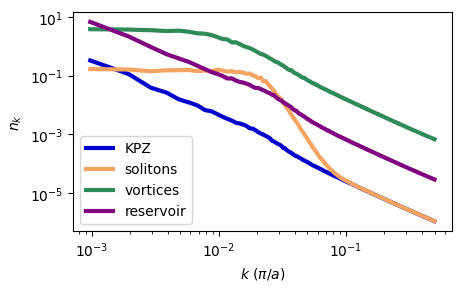

In [27]:
##############
## load data
##############

Nx = 1024
k = fftshift(fftfreq(Nx))

## KPZ regime
p = 1.26
mu = 0.1
sigma = 0.1
ep = condensate_call(Nx, p, mu, sigma)

nk_kpz = np.load(datapath_global + '/Regime_KPZ' + '/nk_KPZ.npy')
nk_kpz /= (Nx * ep.rho * 2 * np.pi)

## Solitons regime 
p = 1.26
mu = 0.29
sigma = 0.1
ep = condensate_call(Nx, p, mu, sigma)

nk_sol = np.load(datapath_global + '/Regime_Solitons' + '/nk_Sol.npy')
nk_sol /= (Nx * ep.rho * 2 * np.pi)


## Vortex regime 
p = 1.26
mu = 0.1
sigma = 9.0
ep = condensate_call(Nx, p, mu, sigma)

nk_vor = np.load(datapath_global + '/Regime_Vortices' + '/nk_Vor.npy')
nk_vor /= (Nx * ep.rho * 2 * np.pi)

## Reservoir regime
p = 1.68
mu = 0.1
sigma = 1.0
ep = condensate_call(Nx, p, mu, sigma)

nk_res = np.load(datapath_global + '/Regime_Reservoir' + '/nk_Res.npy')
nk_res /= (Nx * ep.rho * 2 * np.pi)

##################################################################################
## plot typical nk (in Figure 13 the normalization is changed to match the tails)
##################################################################################
lw = 3
fig, ax = plt.subplots(1, figsize=(4.5, 2.8), layout='constrained')

ax.loglog(k[k>0], nk_kpz[k>0], lw=lw, c='mediumblue', label = r'KPZ')
ax.loglog(k[k>0], nk_sol[k>0], lw=lw, c ='sandybrown', label=r'solitons')
ax.loglog(k[k>0], nk_vor[k>0], lw=lw, c='seagreen', label=r'vortices')
ax.loglog(k[k>0], nk_res[k>0], lw=lw, c='purple', label=r'reservoir')

ax.set_xlabel(r'$k$ $(\pi / a)$')
ax.set_ylabel(r'$n_k$')
plt.legend()

plt.show()

## Figure 14
<img src="figures_paper/Figure14.png" alt="image" width="250" height="auto">

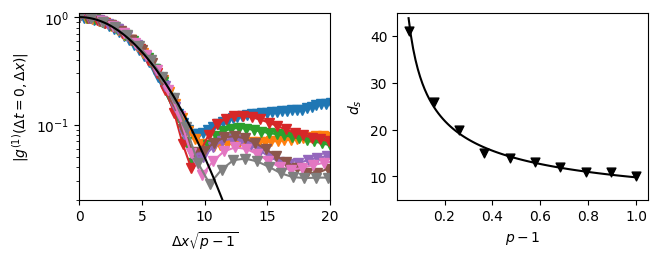

In [11]:
###################
## load data
###################

## data location
datapath = datapath_global + '/Regime_Solitons'

## simulation parameters (for info)
Nx = 128   # number of lattice points
t_in = 15000 # initial transient time (ps)
t_sim = 500 # window of time average

## model parameters
mu = 2.0
eta = 0.1
p_list  = np.linspace(1.05, 2, 10)

## observables
g1x_list = np.load(datapath + '/g1x_list.npy')  # list of g1(x): time-averaged spatial coherence, for p in p_list
x = np.arange(Nx//2) # grid of space points

################################
# plot spatial correlations
################################

fig, Ax = plt.subplots(1, 2, figsize=(6.5, 2.5), layout='constrained')
ax, ax1 = Ax

## plot g1(x)
for i in range(1, len(p_list[1:])):
    d_sol = (p_list[i]-1)**-.5 # p_dependent length scale
    ax.semilogy(x / d_sol, np.abs(g1x_list[i, :]), marker='v', markersize=7)

## Gaussian guideline
xx = np.linspace(0, 15, 100)
a = 0.03
yy = np.exp(- a * xx**2)
ax.semilogy(xx, yy, c='k')
    
## settings
ax.set_xlim(-.01, 20)
ax.set_ylim(2e-2, 1.1)
ax.set_ylabel(r'$|g^{(1)}(\Delta t=0, \Delta x)|$')
ax.set_xlabel(r'$\Delta x \sqrt{p-1}$')

################################
## plot soliton distance vs p-1
################################

## load data of soliton distances 'D_sol', for p in p_list
D_sol = np.load(datapath + '/D_sol.npy') 

## 1/sqrt(p-1) guideline
xx = np.linspace(1.05, 2, 100) - 1
ax1.plot(xx, 9.8*xx**-.5, color='black', label=r'$d_0 / \sqrt{p-1}$')

## plot (D_sol) vs (p-1)
ax1.scatter(p_list-1, D_sol, marker='v', s=40, edgecolor='black', color='k')

## settings
ax1.set_ylim(5, 45)
ax1.set_xlabel(r'$p-1$')
ax1.set_ylabel(r'$d_s$')

plt.show()

## Figure 15
These plots are just an alternative representation of the data in Figure 4 (a), (b)
<img src="figures_paper/Figure15_a.png" alt="image" width="100" height="auto">
<img src="figures_paper/Figure15_b.png" alt="image" width="100" height="auto">
<img src="figures_paper/Figure15_c.png" alt="image" width="100" height="auto">
<img src="figures_paper/Figure15_d.png" alt="image" width="100" height="auto">

## Figure 16
<img src="figures_paper/Figure16.png" alt="image" width="250" height="auto">

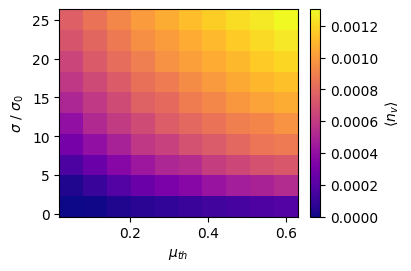

In [12]:
###################
## load data
###################

## data location
datapath = datapath_global + '/PhaseDiagram_mu_sigma'

## simulation parameters (for info)
Nx = 1024    # number of lattice points
t_sim = 1000 # time of each simulation (units: ps)
N_sim = 500 # nb of simulations

## model parameters
p = 1.16
eta_list = np.load(datapath + '/eta_list.npy')  # eta_list = np.linspace(1, 25, 10)
mu_list  = np.load(datapath + '/mu_list.npy')   # p_list  = np.linspace(0.05, 0.6, 10)

## observables
Nv_all = np.load(datapath + '/Nv_all.npy')  # vortex density

##################################
## Plot data of Figure 16
##################################

Nv = np.sum(Nv_all, axis=2) # sum of plus+minus charged vortex density

## plot vortex density in the (mu, sigma) plane:

fig, ax = plt.subplots(1, figsize=(4, 2.6), constrained_layout=True)

s =  ax.pcolormesh(mu_list, eta_list, Nv.T, cmap='plasma')

ax.set_xlabel(r'$\mu_{th}$')
ax.set_ylabel(r'$\sigma$ / $\sigma_0$')
cbar = fig.colorbar(s,ax=ax)
cbar.set_label(r'$\langle n_v \rangle$')

plt.show()

## Figure 17

This Figure pictures a zoom over a non-special window of the realisation given in Figure 3.

It features the phase gradient $u_x(x, t) = \partial_x \theta(x, t)$, and the current density $J(x, t) = \rho(x, t) u_x(x, t)$

#### Figure 17 (a)
<img src="figures_paper/Figure17_a.png" alt="image" width="350" height="auto">

#### Figure 17 (b)
<img src="figures_paper/Figure17_b.png" alt="image" width="350" height="auto">